<h1><b>인공지능개론 6주차 과제<br></b></h1>
<p>컴퓨터공학과 202136038 조성준</p>


---

<h1><b>Pytorch 분류(diabetes.csv)<br></b></h1>

---



<h2><b>0. 라이브러리 import(분류)</b></h2>

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# pytorch관련 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

<h2><b>1. 데이터 로딩</b></h2>

In [50]:
# URL
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv"

# URL에서 직접 CSV 불러오기
df = pd.read_csv(url)

# 데이터 확인
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [51]:
# 컬렴명 확인
print(df.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


<h2><b>2. 결측치 확인</b></h2>

In [52]:
# 결측치 확인
print(df.isnull().sum())
# 확인 결과: 결측치가 확인되지않음

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


<h2><b>3. 레이블 확인(imbalanced data)</b></h2>
<li>타겟 변수의 분포를 확인</li>

,count
Outcome,
0,500
1,268


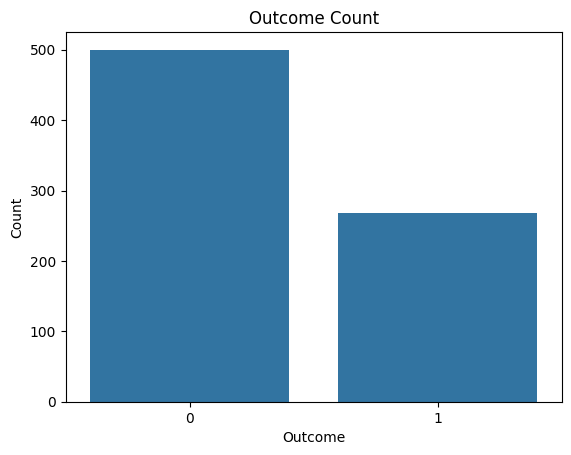

In [53]:
# 레이블 갯수 확인 (그래프)
sns.countplot(data=df, x="Outcome")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.title("Outcome Count")
# 레이블 갯수 확인 (숫자)
df['Outcome'].value_counts()

<h2><b>4. 데이터 전처리</b></h2>

In [54]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

# 3. 훈련/검증 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 정규화 (표준화)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# 5. PyTorch Dataset 정의
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 6. Dataset & DataLoader 생성
train_loader = DataLoader(DiabetesDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(DiabetesDataset(X_val, y_val), batch_size=32, shuffle=False)

<h2><b>5. 모델 정의</b></h2>

In [55]:
import torch.nn as nn

class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(8, 64),       # 입력은 8개 피처
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),       # 이진 분류라 출력은 1
            nn.Sigmoid()            # 확률값으로 출력
        )

    def forward(self, x):
        return self.network(x)

model = DiabetesModel()

<h2><b>6. 손실함수 및 옵티마이져 기법 정의</b></h2>

In [56]:
# 1. 손실 함수 (이진 분류에 적합)
criterion = nn.BCELoss()

# 2. 옵티마이저 (Adam이 보통 안정적이고 빠름)
optimizer = optim.Adam(model.parameters(), lr=0.001)

<h2><b>7. 모델 학습 </b></h2>

In [57]:
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        y_batch = y_batch.unsqueeze(1)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

        preds = (outputs > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(total_loss / total)
    train_accuracies.append(correct / total)

    # 검증
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_batch = y_batch.unsqueeze(1)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_losses.append(val_loss / val_total)
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc={train_accuracies[-1]:.4f}, Val Acc={val_accuracies[-1]:.4f}")


Epoch 1: Train Acc=0.5505, Val Acc=0.7078
Epoch 2: Train Acc=0.7410, Val Acc=0.7532
Epoch 3: Train Acc=0.7541, Val Acc=0.7597
Epoch 4: Train Acc=0.7655, Val Acc=0.7532
Epoch 5: Train Acc=0.7638, Val Acc=0.7597
Epoch 6: Train Acc=0.7704, Val Acc=0.7662
Epoch 7: Train Acc=0.7785, Val Acc=0.7662
Epoch 8: Train Acc=0.7834, Val Acc=0.7597
Epoch 9: Train Acc=0.7834, Val Acc=0.7597
Epoch 10: Train Acc=0.7834, Val Acc=0.7597
Epoch 11: Train Acc=0.7818, Val Acc=0.7597
Epoch 12: Train Acc=0.7883, Val Acc=0.7597
Epoch 13: Train Acc=0.7850, Val Acc=0.7532
Epoch 14: Train Acc=0.7850, Val Acc=0.7597
Epoch 15: Train Acc=0.7883, Val Acc=0.7662
Epoch 16: Train Acc=0.7932, Val Acc=0.7662
Epoch 17: Train Acc=0.8062, Val Acc=0.7597
Epoch 18: Train Acc=0.7980, Val Acc=0.7662
Epoch 19: Train Acc=0.8013, Val Acc=0.7532
Epoch 20: Train Acc=0.7997, Val Acc=0.7662
Epoch 21: Train Acc=0.8062, Val Acc=0.7662
Epoch 22: Train Acc=0.7980, Val Acc=0.7597
Epoch 23: Train Acc=0.7997, Val Acc=0.7662
Epoch 24: Train Acc=

<h2><b>8. 학습곡선 시각화 </b></h2>

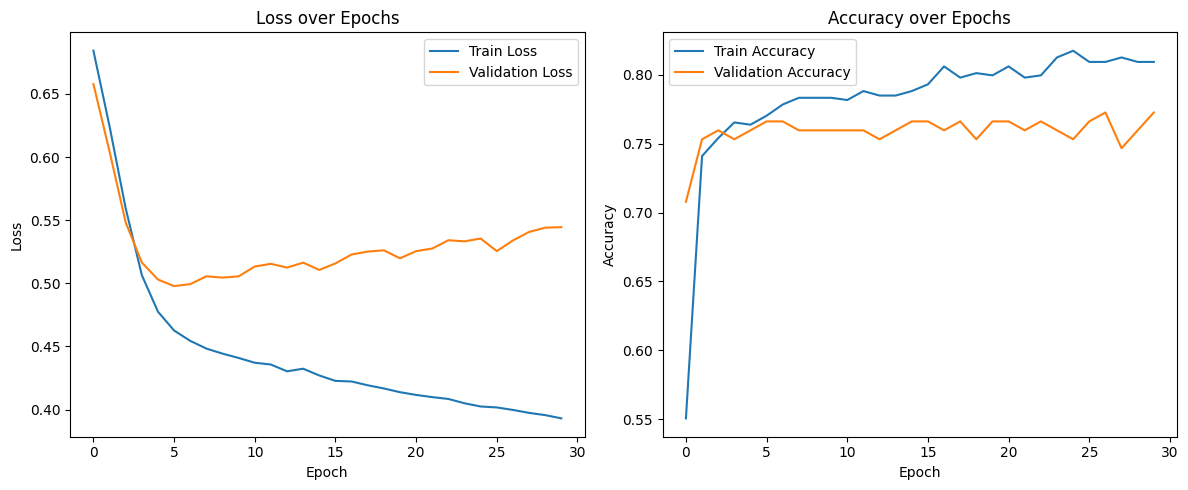

In [58]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

<h2><b>9. 모델 평가 </b></h2>

              precision    recall  f1-score   support

Non-Diabetic       0.81      0.85      0.83        99
    Diabetic       0.70      0.64      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.75       154
weighted avg       0.77      0.77      0.77       154



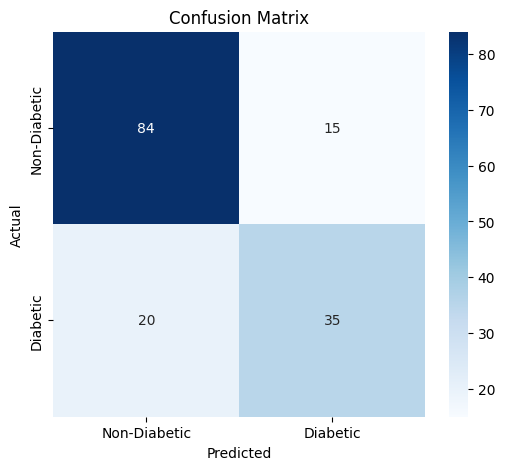

In [59]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 평가 모드로 전환
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        preds = (outputs > 0.5).int()  # 확률 → 0 or 1
        all_preds.extend(preds.numpy().flatten())
        all_labels.extend(y_batch.numpy().flatten())

# 클래스 이름 직접 지정
class_names = ["Non-Diabetic", "Diabetic"]

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
